In [61]:
#pip install findspark
#/usr/local/opt/apache-spark/libexec/sbin
#./start-thriftserver.sh

In [62]:
import findspark
findspark.init()

In [1]:
import pyspark
from pyspark.sql import SparkSession

spark = SparkSession.builder.appName("spark")\
.config('spark.driver.memory', '48g')\
.config("hive.server2.thrift.port", 10000)\
.config("spark.sql.hive.thriftServer.singleSession", True)\
.config("spark.driver.maxResultSize", "10g")\
.enableHiveSupport()\
.getOrCreate()


Using Spark's default log4j profile: org/apache/spark/log4j-defaults.properties
Setting default log level to "WARN".
To adjust logging level use sc.setLogLevel(newLevel). For SparkR, use setLogLevel(newLevel).
22/04/16 12:35:52 WARN NativeCodeLoader: Unable to load native-hadoop library for your platform... using builtin-java classes where applicable
22/04/16 12:35:52 WARN Utils: Service 'SparkUI' could not bind on port 4040. Attempting port 4041.


In [64]:
# from pyspark.sql.types import StructType, StructField
# from pyspark.sql.types import DoubleType, IntegerType, StringType,TimestampType
# from pyspark.sql.types import DateType
# from pyspark.sql.functions import to_timestamp
# from pyspark.files import SparkFiles
# from pyspark.ml.feature import VectorAssembler
# from pyspark.ml.clustering import KMeans
# from pyspark.ml.evaluation import ClusteringEvaluator

# schema = StructType([
#     StructField("ID", IntegerType()),
#     StructField("Speed", DoubleType()),
#     StructField("TravelTime", IntegerType()),
#     StructField("Status", IntegerType()),
#     StructField("timedate", StringType()),
#     StructField("LinkId", IntegerType()),
#     StructField("LinkPoints", StringType()),
#     StructField("EncodedLinkPoints", StringType()),
#     StructField("EncodedPolyLineLvls", StringType()),
#     StructField("Owner", StringType()),
#     StructField("TranscomId", IntegerType()),
#     StructField("Borough", StringType()),
#     StructField("Link_Name", StringType())
# ])

# #spark.sparkContext.addFile("/Users/minoseah629/Repos/AIT614Project/Data_Preparation/Python/Raw_Data/raw.csv")
# #file://Users/minoseah629/Repos/AIT614Project/Data_Preparation/Python/Raw_Data/raw.csv
# schema1 = "ID bigint, Speed float, TravelTime int, Status int, TimeDate string, LinkId int, LinkPoints string, EncodedLinkPoints string, EncodedPolyLineLvls string, Owner string, TranscomId int, Borough string,Link_Name string"
# df2 = spark.read.format('csv').option("header", "true").schema(schema).load('/Users/minoseah629/Downloads/DOT_Traffic_Speeds_NBE.csv')
# #.csv(SparkFiles.get("raw.csv"), schema=schema,header=True)
# df2.printSchema()
# # .option("inferSchema", "true")

In [65]:
# df2 = df2.withColumn("timedate", to_timestamp("timedate", 'MM/dd/yyyy hh:mm:ss a'))
# df2.na.drop()
# df2.createOrReplaceTempView("dataset")

# df2.count()
# df2.printSchema()

In [7]:
from pyspark.ml.feature import VectorAssembler
from pyspark.ml.clustering import KMeans
from pyspark.ml.evaluation import ClusteringEvaluator

In [8]:
data = spark.read.format('parquet').load("/Users/minoseah629/Repos/AIT614Project/ewin/spark-warehouse/ait614projectpermanenttable")
data.createOrReplaceTempView("dataset")

In [9]:
columns = 'hour(timedate) `hour`,minute(timedate) `minute`,weekday(timedate) `weekday`,year(timedate) `year`,month(timedate) `month`,day(timedate) `day`,dayofyear(timedate) as `day_of_year`'

In [12]:
df3 = spark.sql('select id, speed, traveltime, '+columns+' from dataset')

In [10]:
assemble = VectorAssembler(inputCols=[
    'speed',
    'traveltime',
    'hour',
    'minute',
    'weekday',
    'year',
    'month',
    'day',
    'day_of_year'], outputCol='features')

In [13]:
assembled_data = assemble.transform(df3)


In [72]:
assembled_data.show(2)

+---+-----+----------+----+------+-------+----+-----+---+-----------+--------------------+
| id|speed|traveltime|hour|minute|weekday|year|month|day|day_of_year|            features|
+---+-----+----------+----+------+-------+----+-----+---+-----------+--------------------+
|330|16.77|       294|  17|    58|      1|2021|   12|  7|        341|[16.77,294.0,17.0...|
|212|45.98|       236|  17|    58|      1|2021|   12|  7|        341|[45.98,236.0,17.0...|
+---+-----+----------+----+------+-------+----+-----+---+-----------+--------------------+
only showing top 2 rows



In [14]:
from pyspark.ml.feature import StandardScaler
scale=StandardScaler(inputCol='features',outputCol='standardized')
data_scale=scale.fit(assembled_data)
data_scale_output=data_scale.transform(assembled_data)
data_scale_output.show(2)

+---+-----+----------+----+------+-------+----+-----+---+-----------+--------------------+--------------------+
| id|speed|traveltime|hour|minute|weekday|year|month|day|day_of_year|            features|        standardized|
+---+-----+----------+----+------+-------+----+-----+---+-----------+--------------------+--------------------+
|330|16.77|       294|  17|    58|      1|2021|   12|  7|        341|[16.77,294.0,17.0...|[0.84562176951510...|
|212|45.98|       236|  17|    58|      1|2021|   12|  7|        341|[45.98,236.0,17.0...|[2.31852647360194...|
+---+-----+----------+----+------+-------+----+-----+---+-----------+--------------------+--------------------+
only showing top 2 rows



In [15]:
silhouette_score=[]
evaluator = ClusteringEvaluator(predictionCol='prediction', featuresCol='standardized', \
                                metricName='silhouette', distanceMeasure='squaredEuclidean')

In [ ]:
# permanent_table_name = 'kmeans'
# for i in range(2,10):    
#     KMeans_algo=KMeans(featuresCol='standardized', k=i)
#     KMeans_fit=KMeans_algo.fit(data_scale_output)    
#     output=KMeans_fit.transform(data_scale_output)
#     output.write.format("parquet").saveAsTable(permanent_table_name+str(i))
#     #score=evaluator.evaluate(output)
#     #silhouette_score.append(score)
#     #print("Silhouette Score:",score)

In [ ]:
permanent_table_name = 'kmeans'
for i in range(2,10):
    output=spark.read.format("parquet").load('/Users/minoseah629/Repos/AIT614Project/ewin/spark-warehouse/kmeans'+str(i))
    score=evaluator.evaluate(output)
    silhouette_score.append(score)
    print("Silhouette Score:",score)

Silhouette Score: 0.2888635315464123


Silhouette Score: 0.20198519851171706


Silhouette Score: 0.15747950772325925


Silhouette Score: 0.1566023749991986


Silhouette Score: 0.18076474118016772


Silhouette Score: 0.1729575289123795


Silhouette Score: 0.17353065883484703


Silhouette Score: 0.17722725698699374


Text(0, 0.5, 'cost')

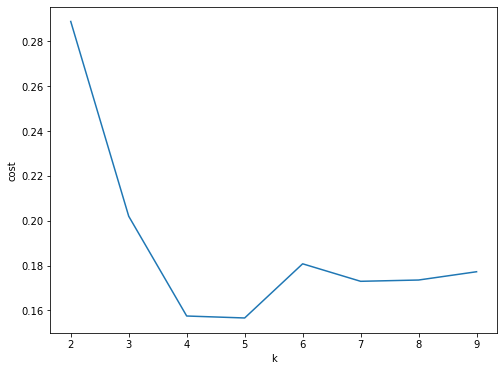

In [ ]:
#Visualizing the silhouette scores in a plot
import matplotlib.pyplot as plt
fig, ax = plt.subplots(1,1, figsize =(8,6))
ax.plot(range(2,10),silhouette_score)
ax.set_xlabel('k')
ax.set_ylabel('cost')

In [16]:
from pyspark.ml.feature import PCA as PCAml
pca = PCAml(k=3, inputCol="features", outputCol="pca")
pca_model = pca.fit(assembled_data)
pca_transformed = pca_model.transform(assembled_data)

22/04/15 21:40:35 WARN InstanceBuilder$NativeBLAS: Failed to load implementation from:dev.ludovic.netlib.blas.JNIBLAS
22/04/15 21:40:35 WARN InstanceBuilder$NativeBLAS: Failed to load implementation from:dev.ludovic.netlib.blas.ForeignLinkerBLAS
22/04/15 21:41:01 WARN LAPACK: Failed to load implementation from: com.github.fommil.netlib.NativeSystemLAPACK
22/04/15 21:41:01 WARN LAPACK: Failed to load implementation from: com.github.fommil.netlib.NativeRefLAPACK


In [ ]:
# pca_transformed.write.format('parquet').saveAsTable('pca_transformed')

In [2]:
pca_transformed = spark.read.format('parquet').load("/Users/minoseah629/Repos/AIT614Project/ewin/spark-warehouse/pca_transformed")

In [ ]:
pca_transformed.show()

+---+-----+----------+----+------+-------+----+-----+---+-----------+--------------------+--------------------+
| id|speed|traveltime|hour|minute|weekday|year|month|day|day_of_year|            features|                 pca|
+---+-----+----------+----+------+-------+----+-----+---+-----------+--------------------+--------------------+
|330|16.77|       294|  17|    58|      1|2021|   12|  7|        341|[16.77,294.0,17.0...|[294.312407798787...|
|212|45.98|       236|  17|    58|      1|2021|   12|  7|        341|[45.98,236.0,17.0...|[236.214217963330...|
|205|41.63|       384|  17|    58|      1|2021|   12|  7|        341|[41.63,384.0,17.0...|[384.227980960702...|
|318|24.85|       159|  17|    58|      1|2021|   12|  7|        341|[24.85,159.0,17.0...|[159.285980485947...|
|211|49.08|       336|  17|    58|      1|2021|   12|  7|        341|[49.08,336.0,17.0...|[336.203142500475...|
|319|27.34|       352|  17|    58|      1|2021|   12|  7|        341|[27.34,352.0,17.0...|[352.276389392

In [3]:
output=spark.read.format("parquet").load('/Users/minoseah629/Repos/AIT614Project/ewin/spark-warehouse/kmeans3')

In [4]:
from pyspark.sql.window import Window
from pyspark.sql.functions import row_number

windowSpec =Window.partitionBy("id").orderBy("year","month","day","hour","minute")

In [5]:
output.filter(output.year > 2017).withColumn("row_number",row_number().over(windowSpec)).createOrReplaceTempView('kmeans3')


In [6]:
pca_transformed.filter(pca_transformed.year > 2017).withColumn("row_number",row_number().over(windowSpec)).createOrReplaceTempView('pca')

In [19]:
spark.sql('select * from kmeans3').show()

+---+-----+----------+----+------+-------+----+-----+---+-----------+--------------------+--------------------+----------+----------+
| id|speed|traveltime|hour|minute|weekday|year|month|day|day_of_year|            features|        standardized|prediction|row_number|
+---+-----+----------+----+------+-------+----+-----+---+-----------+--------------------+--------------------+----------+----------+
|137|53.43|        83|   0|     2|      0|2018|    1|  1|          1|[53.43,83.0,0.0,2...|[2.69419028892022...|         1|         1|
|137|57.78|        77|   0|     7|      0|2018|    1|  1|          1|[57.78,77.0,0.0,7...|[2.91353761732754...|         1|         2|
|137|57.16|        77|   0|    12|      0|2018|    1|  1|          1|[57.16,77.0,0.0,1...|[2.88227431994534...|         1|         3|
|137|54.05|        82|   0|    17|      0|2018|    1|  1|          1|[54.05,82.0,0.0,1...|[2.72545358630241...|         1|         4|
|137|57.16|        77|   0|    22|      0|2018|    1|  1|     

In [20]:
spark.sql('select * from pca').show()

+---+-----+----------+----+------+-------+----+-----+---+-----------+--------------------+--------------------+----------+
| id|speed|traveltime|hour|minute|weekday|year|month|day|day_of_year|            features|                 pca|row_number|
+---+-----+----------+----+------+-------+----+-----+---+-----------+--------------------+--------------------+----------+
|137|53.43|        83|   0|     2|      0|2018|    1|  1|          1|[53.43,83.0,0.0,2...|[82.8615606841881...|         1|
|137|57.78|        77|   0|     7|      0|2018|    1|  1|          1|[57.78,77.0,0.0,7...|[76.8469150766779...|         2|
|137|57.16|        77|   0|    12|      0|2018|    1|  1|          1|[57.16,77.0,0.0,1...|[76.8490000569077...|         3|
|137|54.05|        82|   0|    17|      0|2018|    1|  1|          1|[54.05,82.0,0.0,1...|[81.8594548637867...|         4|
|137|57.16|        77|   0|    22|      0|2018|    1|  1|          1|[57.16,77.0,0.0,2...|[76.8489865528146...|         5|
|137|53.43|     

In [7]:
pca = spark.sql('select prediction, pca.pca from kmeans3 inner join pca on pca.row_number = kmeans3.row_number')
schema = pca.schema
#pca.write.format('parquet').mode('overwrite').saveAsTable('x_pca')

In [36]:
# schema = StructType([    
#     StructField("prediction",IntegerType(),True),
#     StructField("pca",
#         ArrayType(
#             StructType(
#             [
#                 StructField("pca1", DoubleType(),False),
#                 StructField("pca2", DoubleType(),False),
#                 StructField("pca3", DoubleType(),False)
#             ]
#             )
#         ,False)
#     ,False)
# ])

pca

In [44]:
# from pyspark.sql.types import *
# from pyspark.sql.types import StructType, StructField
# from pyspark.sql.types import DoubleType, IntegerType, StringType,TimestampType
# from pyspark.sql.types import ArrayType

# from pyspark.ml.linalg import VectorUDT

# pca=spark.read.format("parquet").schema(schema).load('/Users/minoseah629/Repos/AIT614Project/ewin/spark-warehouse/x_pca')

In [30]:
pca.first()

Row(prediction=1, pca=DenseVector([78.8535, -5.86, 65.141]))

In [14]:
windowSpec1 =Window.partitionBy("prediction").orderBy("prediction")
list = pca.withColumn("row_number",row_number().over(windowSpec1))

In [ ]:
# import numpy as np

# pca.write.format('parquet').saveAsTable('x_pca')


In [22]:
pca.head()


Row(prediction=1, pca=DenseVector([78.8535, -5.86, 65.141]))

In [23]:
#cluster_assignment = output.rdd.map(lambda row: row.prediction).collect()

In [17]:
# import seaborn as sns
# import matplotlib.pylab as plt

# pca_data = np.hstack((x_pca, np.array(cluster_assignment)))

In [30]:
# display(pca_data)

array(['pca', '2', '2', ..., '2', '2', '2'], dtype='<U21')

In [37]:
# list = output1.rdd.map(lambda row: row.prediction).filter(lambda x : x ==2).collect()
#assignments= spark.createDataFrame(list)


In [38]:
# display(len(list))

27200620

In [25]:
# import pandas as pd
# pdf = pd.array(list)

In [ ]:
# import pandas as pd
# pca_df = pd.DataFrame(data=pca_data, columns=("1st_principal", "2nd_principal","cluster_assignment"))


In [11]:
# sns.FacetGrid(pca_df,hue="cluster_assignment", height=6).map(plt.scatter, '1st_principal', '2nd_principal' ).add_legend()

plt.show()

NameError: name 'plt' is not defined

In [ ]:
display(x_pca.first().pca)

In [42]:
pca.show()

AttributeError: 'NoneType' object has no attribute 'show'

In [48]:
pca1 = pca.select("pca")
display(pca1)


DataFrame[pca: vector]

+--------------------+
|                 pca|
+--------------------+
|[78.8535429872077...|
|[773.240015078296...|
|[0.04269101665262...|
|[115.851223038386...|
|[133.880463741225...|
|[129.846953221627...|
|[310.862604406790...|
|[26.8664478552491...|
|[78.8220995278275...|
|[90.8367013752027...|
|[167.857177498449...|
|[115.838638907110...|
|[129.863720817455...|
|[46.8893672876119...|
|[90.9457076168953...|
|[0.04269101665262...|
|[0.04269101665262...|
|[49.8495383950821...|
|[84.8576894436721...|
|[1249.26224736583...|
+--------------------+
only showing top 20 rows



In [50]:
pca1.first()[0][2]

65.14100179390937

In [58]:
windowSpec1 =Window.partitionBy("prediction").orderBy("prediction")

In [ ]:
pcadict = pca.withColumn("row_number",row_number().over(windowSpec1))
display(pcadict)

1

In [ ]:
list.show()

In [ ]:
list = pca.collect()

In [8]:
dict = list.rdd.map(lambda row: (row.prediction, row.pca)).collect().todict()

AttributeError: type object 'list' has no attribute 'rdd'

In [3]:
pca=spark.read.format("parquet").load('/Users/minoseah629/Repos/AIT614Project/ewin/spark-warehouse/x_pca')

In [5]:
list1 = pca.rdd.map(lambda x : x.asDict()).collect()

In [43]:
xarray = []
yarray = []
zarray = []
parray = []
for x in list1[:]:
    xarray.append(x.get("pca")[0])
    yarray.append(x.get("pca")[1])
    zarray.append(x.get("pca")[2])
    parray.append(x.get("prediction"))



In [45]:
display(max(xarray))
display(max(yarray))
display(max(zarray))

340494.2455217763

360.08850070966656

1158.9678005295752

/var/folders/6g/wst_75wx36bf65vy03zgqw_r0000gn/T/ipykernel_525/4094635012.py:4: MatplotlibDeprecationWarning: Calling gca() with keyword arguments was deprecated in Matplotlib 3.4. Starting two minor releases later, gca() will take no keyword arguments. The gca() function should only be used to get the current axes, or if no axes exist, create new axes with default keyword arguments. To create a new axes with non-default arguments, use plt.axes() or plt.subplot().
  threedee = plt.figure(figsize=(5,8)).gca(projection='3d', autoscale_on=True)


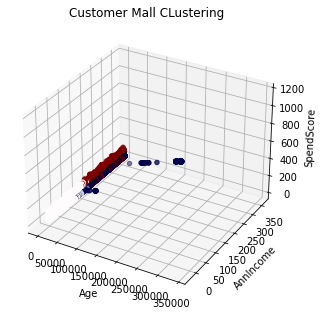

In [48]:
from mpl_toolkits.mplot3d import Axes3D
import matplotlib.pyplot as plt
#Create 3d visualization
threedee = plt.figure(figsize=(5,8)).gca(projection='3d', autoscale_on=True)

threedee.scatter(xarray, yarray, zarray,c=parray, cmap="seismic")
threedee.set_title('Customer Mall CLustering')
threedee.set_xlabel('Age')
threedee.set_ylabel('AnnIncome')
threedee.set_zlabel('SpendScore')
plt.show()

everything before chart cell 18 https://towardsdatascience.com/k-means-clustering-using-pyspark-on-big-data-6214beacdc8b

https://www.data4v.com/tutorial-k-means-clustering-on-spark/

https://github.com/elsyifa/Clustering-Pyspark/blob/master/Clustering%20Using%20Pyspark_v2.ipynb
https://andrewmourcos.github.io/blog/2019/06/06/PCA.html?msclkid=658ba0e2bcea11ecbea027e6fdcfaf6c

In [60]:
spark.stop()